# Capacity Project

Writen by: Oscar Reula (oreula@gmail.com)

This code is writen in Fenics/Python, it is used to compute the resonant frequencies and eigenvectors of a cavity. At the moment is 2-dimensional, that is it corresponds to infinite long structures in the  ẑ direction. 
This restriction is mainly due to have a code that can run in home computers in very short time.

First the theory: we need to solve the following eigenfuntion problem for the electric field:

$\nabla \wedge (\nabla \wedge \vec{E})  = \lambda \vec{E} \quad\quad\text{ in $\Omega$}$

$\vec{E} \wedge \hat{n}= 0 \text{ on $\partial\Omega$}$

Where $\Omega$ is some 2-dimensional region, we think for this problem as the electric field having zero $\hat{z}$ component. Here $\lambda = \frac{\omega^2}{c^2}$ with $\omega$ the mode frequency and $c$ the speed of light.
Notice that if the take the divergence of the right hand side of the equation we get identically zero, thus, all the modes must have zero divergence, but also implies that the operator at the right hand side has a big kernel.
Thus, to solve the problem as a variational one we must restrict the space to that of vectors with zero divergence.
It is only in this space that the operator is elliptic.

In order to use finite elements we need to express the problem as a weak one:

$$
\int_{\Omega} \nabla \wedge \vec{E}\,\cdot \nabla \wedge \vec{V}\, {\rm d} x
= \lambda \int_{\Omega} \vec{E} \cdot \vec{V}\, {\rm d} x \quad \forall \ \vec{V}\in H_0(\nabla \wedge),
$$

Where the space $H_0(\nabla \wedge)$ is the space of vectors which have zero divergence. 

We shall have a test case, namely:

$\nabla \wedge (\nabla \wedge \vec{E})  = \lambda \vec{E} \quad\quad\text{ in $\Omega$} \quad\quad\quad
\Omega = (0,\pi)\times(0,\pi)$

For this case we know the solutions: (see for instance: http://www.famaf.unc.edu.ar/~reula/Docencia/Electromagnetismo/electrodynamics.pdf, Sec. 19.1)

$\vec{E}(x,y) = (m\cos(n x)\sin(m y), -n\cos(m y)\sin(n x)), \quad \lambda = m^2 + n^2,$ $\quad \lambda = 1, 1, 2, 4, 4, 5, 5, 8, 9, 9, 10, 10, 13, 13, \dots$

We use this case to check that what we are doing is correct. 


We are going to compute the eigenvectors for regions with several disconected boundaries. In that case there are an infinite set of zero mode solutions. The equations for the zero modes are just Laplace's equation for a potential,
where the boundary condition is that in each boundary the potential is constant. That problem as a n-parameter family of solutions, where the parameters are the potential's value at the n boundaries. Taking out a normalization constant we see that there remain n-1 parameters in the continuum. If the potentials are not all equal we then have a non-zero electric field and so a zero-mode for each set of parameter values.

The code we are using is based in the page: https://github.com/FEniCS/dolfin/blob/master/demo/documented/maxwell-eigenvalues/python/demo_maxwell-eigenvalues.py.rst

We first call all the libraries needed. You can find a very good tutorial for Fenics at: http://launchpad.net/fenics-book/trunk/final/+download/fenics-book-2011-10-27-final.pdf



In [1]:
from dolfin import *

if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()
if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

In [2]:
from __future__ import print_function
#from fenics import *

In [3]:
from mshr import *
from math import pi


import numpy as np
import matplotlib.pyplot as mpl

Once the libraries are imported and the is no issue we create the meshes for the region of interest.

We shall use a square mesh for testing and then several ones for experimenting: 
## rectangle: 
It consists of a box like the one before but a side can be enlarged
## square with a circular hole:
A square with a circular hole in its interior. It is centered on the square, but then one can experiment moving it from the center. What would happend?
## circle with a circular hole: 
You can also move the hole here.


With the boolean assignments you can choose between cases.

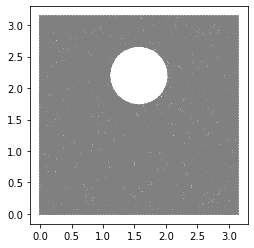

In [18]:
# Create mesh 


test = False
rectangle = False
case_1 = False
case_2 = False

#test = True
#rectangle = True
case_1 = True
#case_2 = True


if test: 
    L=1.
    side_x = L*pi
    side_y = L*pi
    
if rectangle:
    L=2.
    asimetria = 1.0 # si diferente de UNO da una asimetría y los autovalores dejan de ser degenerados.
    side_x = L*pi
    side_y = L*pi*asimetria
    
if case_1: # square - circle
    side_x = pi
    side_y = pi
    square =  Rectangle(Point(0, 0), Point(side_x,side_y))
    displacement = pi*0.2

    cy_center_x = 0.5*pi
    cy_center_y = 0.5*pi + displacement
    cy_radious = 0.15*pi

    square =  Rectangle(Point(0, 0), Point(side_x,side_y))
    cylinder =  Circle(Point(cy_center_x, cy_center_y), cy_radious)

    domain = square - cylinder

    mesh =  generate_mesh(domain, 62)
    
if case_2: # circle - circle
    
    cy_center_x = 0.
    cy_center_y = 0.
    cy_inner_radious = 0.5*pi
    cy_outer_radious = 1.0*pi
    
    big_cylinder =  Circle(Point(cy_center_x, cy_center_y), cy_outer_radious)
    small_cylinder =  Circle(Point(cy_center_x, cy_center_y), cy_inner_radious)
    
    domain = big_cylinder - small_cylinder
    
    mesh =  generate_mesh(domain, 32)
    
if test or rectangle:  # simple square
    
    # We can use an uniform mesh of a generic one.
    
    #domain = Rectangle(Point(0, 0), Point(side_x,side_y)
    #mesh =  generate_mesh(domain, 64)
    mesh = RectangleMesh(Point(0, 0), Point(side_x, side_y), 40, 40)
    #mesh = RectangleMesh(Point(0, 0), Point(side_x, side_y), 40, 40, "crossed")

plot(mesh)

Once a mesh has been generated we create de function space and give boundary conditions. In this case we give Dirichlet boundary conditions because the function space is a vector space so defined that on the sides of the triangles the vectors are tangent to them, so if they vanish there it means that the vector is normal to that side.

In [19]:

V   = FunctionSpace(mesh, "N1curl", 1) # this space is space of vectors which have zero divergence.

# Define boundary condition


#tol = 1E-14
tol = 1E-2


if test or rectangle:
    
#    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

    class outer_0(SubDomain):
        def inside(self, x, on_boundary):
            return  near(x[0], 0, tol) or near(x[0],side_x, tol) \
                or  near(x[1], 0, tol) or near(x[1],side_y, tol)
    outer0 = outer_0()
    outer0.mark(boundary_markers, 0)
    
    u_outer = Constant((0.0, 0.0))

    bc_out = DirichletBC(V, u_outer, outer0)


    bcs = [bc_out]
    #bcs = [DirichletBC(V, Constant((0.0, 0.0)), DomainBoundary())]
    
    
        # the boundary surface elements 
#    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0) 
    
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

if case_1:
    
#    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    class outer_0(SubDomain):
        def inside(self, x, on_boundary):
            return  near(x[0], 0, tol) or near(x[0],side_x, tol) \
                or  near(x[1], 0, tol) or near(x[1],side_y, tol)
    outer0 = outer_0()
    outer0.mark(boundary_markers, 0)
                                

    class cyl_1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (cy_center_x - cy_radious - tol) and x[0] < (cy_center_x + cy_radious + tol) and x[1] > (cy_center_y - cy_radious - tol) and x[1] < (cy_center_y + cy_radious + tol)
    cyl1 = cyl_1()
    cyl1.mark(boundary_markers,1)



    # the boundary surface elements 
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
             

    u_outer = Constant((0.0, 0.0))
    u_cyl = Constant((0.0, 0.0))


    bc_out = DirichletBC(V, u_outer, outer0)
    bc_cyl = DirichletBC(V, u_cyl, cyl1)


    bcs = [bc_out, bc_cyl]
    
if case_2:
    
#    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    class outer_0(SubDomain):
        def inside(self, x, on_boundary):
            return  near(x[0]*x[0]+x[1]*x[1], cy_outer_radious**2, tol)
    outer0 = outer_0()
    outer0.mark(boundary_markers, 0)
                                

    class inner_1(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0]*x[0]+x[1]*x[1], cy_inner_radious**2, tol)
    inner1 = inner_1()
    inner1.mark(boundary_markers,1)



    # the boundary surface elements 
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
             

    u_outer = Constant((0.0, 0.0))
    u_inner = Constant((0.0, 0.0))


    bc_out = DirichletBC(V, u_outer, outer0)
    bc_in  = DirichletBC(V, u_inner, inner1)


    bcs = [bc_out, bc_in]
    


We are now ready to create the variational problem and apply the solver:

In [20]:
u = TrialFunction(V)
v = TestFunction(V)
a = inner(curl(u), curl(v))*dx
b = inner(u, v)*dx
    #
    # Assemble into PETSc matrices
dummy = v[0]*dx
A = PETScMatrix()
assemble_system(a, dummy, bcs, A_tensor=A)
#[bc.zero(A) for bc in bcs]
B = PETScMatrix()
assemble_system(b, dummy, bcs, A_tensor=B)
    #
[bc.zero(B) for bc in bcs]
    #
#solve now around
point = 2.
eigensolver = SLEPcEigenSolver(A, B)
eigensolver.parameters["solver"] = "krylov-schur"
eigensolver.parameters["problem_type"] = "gen_hermitian"
    #
eigensolver.parameters["spectrum"] = "target magnitude"
eigensolver.parameters["spectral_transform"] = "shift-and-invert"
eigensolver.parameters["spectral_shift"] = point

#eigensolver.parameters["spectrum"] = 'smallest real'
neigs = 40
eigensolver.solve(neigs)
print(eigensolver.get_number_converged())

50


We have already computed the eigenvalues and eigenvectors, in this case close to "point".
We can now manipulate the eigenvalues and compare them with exact values or print them.
You will note that there are many zero eigenvalues, they are spurious, don't take them into account.
We display them in the order they are computed with the solver and also sorted in increasing order.
We just look are the real part because they are real, or they should be...

Real eigenvalues:  [0.7666 0.8728 1.8599 3.4460 4.2355 4.7992 5.2459 7.7328 8.3968 9.4237
 9.6272 9.8367 12.1845 13.5859 15.0692 16.5418 16.7796 17.8204 18.2647
 19.5839 22.7630 23.7787 25.2331 25.4647 25.6983 26.4264 28.7878]
Unsorted: [1.8599 0.8728 0.7666 3.4460 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 -0.0000 4.2355 4.7992
 5.2459 7.7328 8.3968 9.4237 9.6272 9.8367 12.1845 13.5859 15.0692 16.5418
 16.7796 17.8204 18.2647 19.5839 22.7630 23.7787 25.2331 25.4647 25.6983
 26.4264 28.7878]


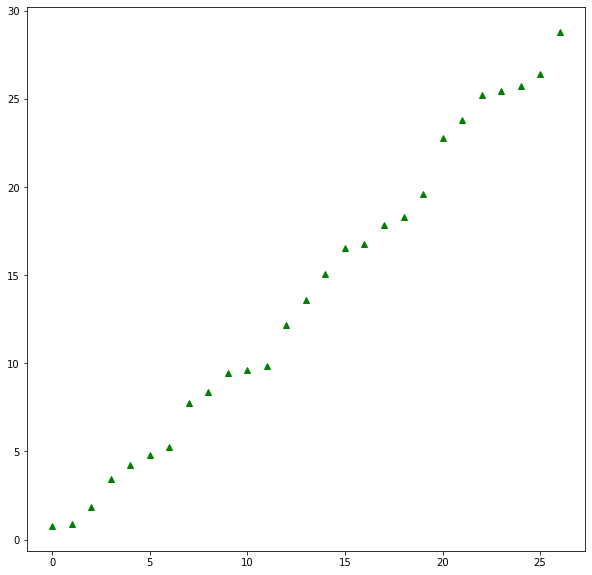

In [21]:
computed_eigenvalues = []
positive_computed_eigenvalues = []
for i in range(min(neigs, eigensolver.get_number_converged())):
    r, _ = eigensolver.get_eigenvalue(i) # ignore the imaginary part
    
    if r>0.00001: # ignore zero eigenvalues
        positive_computed_eigenvalues.append(r)
    computed_eigenvalues.append(r)
    
num_eig = np.sort(np.array(computed_eigenvalues))
pos_num_eig = np.sort(np.array(positive_computed_eigenvalues))
np.set_printoptions(formatter={'float': '{:5.4f}'.format})
print("Real eigenvalues:  {}".format(pos_num_eig))
print("Unsorted: {}".format(np.array(computed_eigenvalues)))


length = len(pos_num_eig)
true_eig = np.sort(np.array([float(m**2 + n**2)\
        for m in range(9) for n in range(9)]))[1:length+1]
x = np.arange(length)
mpl.figure(figsize=(10,10)) 
if test == False:
    mpl.plot(x,pos_num_eig,'g^')
if test:
    print("Exact:    {}".format(true_eig))
    mpl.plot(x,pos_num_eig[:length],'g^',x,true_eig[:length],'r.')

To compare eigenfunctions in the test case it is best to look for one with no degeneracy, like the $\lambda=2$ case.
Otherwise we just normalize them and save in a file.

In [24]:

r, c, rx, cx = eigensolver.get_eigenpair(32)
print('The eigenvalue is: %2.5f'%r)

# save for plotting

u = Function(V)
u.vector()[:] = rx


# Re-scale solution to have L2 norm unity.
u_n = Function(V)

square = inner(u,u)*dx
L2_inv = 1./sqrt(assemble(square))

u_n = project(L2_inv*u,V)
    
square = inner(u_n,u_n)*dx
print("This should be unit = %2.2f"%assemble(square))

# Save solution to file in VTK format


vtkfile_e = File('Cavity/e.pvd')

    
vtkfile_e << u_n    


The eigenvalue is: 19.58390
Calling FFC just-in-time (JIT) compiler, this may take some time.
This should be unit = 1.00


Para una rápida visualización miramos el módulo del campo eléctrico. En el borde, donde el campo es normal al mismo, este módulo nos da idea de la magnitud del cuadrado de la carga superficial.

Object cannot be plotted directly, projecting to piecewise linears.


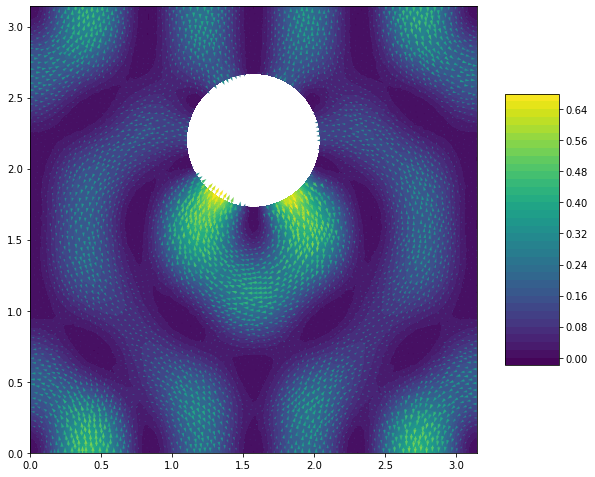

In [25]:
# Plot eigenfunction and mesh
fig = mpl.figure(figsize=(10,10))
modulo = plot(inner(u_n,u_n))
plot(u_n)
#plot(mesh)
fig.colorbar(modulo, shrink=0.5, aspect=5)

For testing we choose the $n=m$ case ($\lambda = 2$) from above.

In [26]:
if test:
    # we compute the exact solution here (you can try others). If not correct invert the signs.
    # This is the n=m=1, lambda = 2 case.
    
    u_D = Expression(('-cos(x[0])*sin(x[1])','sin(x[0])*cos(x[1])'), degree=2)
    u_d = project(u_D,V)
    square = inner(u_d,u_d)*dx
    L2_inv = 1./sqrt(assemble(square))
    u_dd = project(L2_inv*u_d,V)
    
    vtkfile_e_e = File('Cavity/e_e.pvd')
    vtkfile_e_e << u_dd
    
    error_l = inner(u_dd-u_n,u_dd-u_n)*dx
    error = assemble(error_l)
    print("L2 norm of error = %5.5f"%error)
    
    

## Q factor for cavities.


The Q factor is defined as:

$$
\frac{\frac{d\mathcal{E}}{dt}}{\mathcal{E}} = - \frac{\zeta_r}{c\mathcal{Q}}
$$

Here $\zeta_r$ is the penetration length of the material out of which the cavity is made of, $c$ the speed of light.
Actually this definition is not the usual one, which have have incorporated the $\zeta_r$ on it and a frequency outside of it. But this one is better since split the energy loss into factors so that $\mathcal{Q}$ depends only on the geometry, and in fact is length independent.

The $Q$ factor is computed to be:

$$
\mathcal{Q} = \sqrt{\lambda}\frac{\int_{\Omega} |\vec{H}|^2\; dV}{\int_{\partial \Omega}|\vec{H}|^2 \; dS} = \sqrt{\lambda}
\frac{\int_V |\nabla \wedge \vec{E}|^2 \; dV}{\int_{\partial \Omega} |\nabla \wedge  \vec{E}|^2\;dS}
$$

Where we have used that:

$$
\vec{H} = \frac{ic}{\omega} \nabla \wedge \vec{E} = i\frac{1}{\sqrt{\lambda}}\nabla \wedge \vec{E}
$$





Object cannot be plotted directly, projecting to piecewise linears.


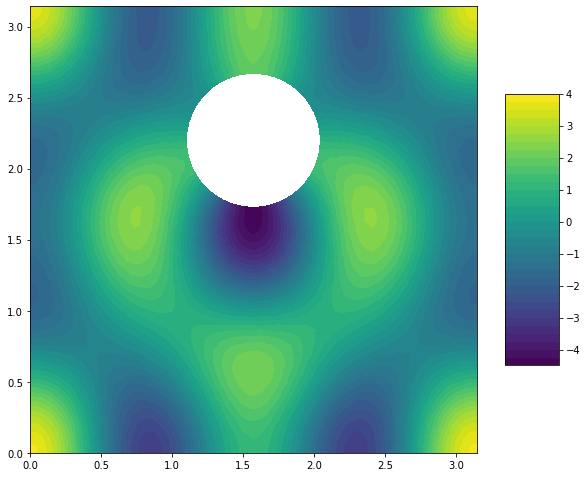

In [27]:
b = Function(V)
b = curl(u_n)

fig_b = mpl.figure(figsize=(10,10))
H = plot(b)
#plot(mesh)
fig_b.colorbar(H, shrink=0.5, aspect=5)

#b = project(curl(u_n),V)



In [28]:
H2_V = assemble(inner(b,b)*dx)
if test:
    H2= inner(b,b)*ds(0)
    H2_int=assemble(H2)
else: 
    H2_0= inner(b,b)*ds(0)
    H2_1= inner(b,b)*ds(1) 
    H2_int=assemble(H2_0) + assemble(H2_1)

Q = sqrt(r)*H2_V/(H2_int) # for this the electric field has to be normalized so that its energy is unit.

print("Cavity factor = %5.5f"%Q)




Cavity factor = 1.48021


## Tarea:

1.- Caso de testeo:

    a) Analize en detalle el caso de prueba, vea que la solución está bien approximada para algunos autovalores.

    b) Cuente los nodos de los campos vectoriales (use pseudocolor de la magnitud del vector para visualizarlos mejor.) Cómo se relacionan estos con los autovalores? Porque algunos autovalores tienen degeneración?
    
    c) Cambie uno de los lados del cuadrado (usando el caso rectangle) y vea que sucede con los autovalores y autovectores.

2.- Caso 1 o Caso 2:
  
    a) Vea si hay degeneración en este caso? Cómo son los nodos? 

    b) Corra el círculo del medio en sentido vertical y vea que pasa con la degeneración, explique. Estudie como se separan los autovalores en función de la asimetría usada.
    
3.- $\mathcal{Q}$ Factors: 

    Para modos simples calcule el $\mathcal{Q}$ de la cavidad. Verifique que si cambiamos todas las magnitudes de la cavidad en forma proporcional (lo que es llamado una dilatación o contracción) el $\mathcal{Q}$ no cambia. Grafique distintos $\mathcal{Q}$ para modos crecientes.
    

## Exploraciones:


1.- Explore otras configuraciones de cavidades.

2.- Resuelva el problema de guías de onda correspondiente a pensar esta cavidad como la sección de la misma.

3.- Inserte un dieléctrico (constante o variable) en parte de la cavidad.

